In [167]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, precision_recall_curve, confusion_matrix
import itertools

In [8]:
with open('../datasets/mobile_app_launches_sessions_payments.pkl', 'rb') as file:
    df = pickle.load(file)

In [22]:
X_train = df['X_train']
y_train = df['y_train']
X_test = df['X_valid']
y_test = df['y_valid']

In [27]:
rfc = RandomForestClassifier(n_estimators=300, random_state=17, class_weight='balanced')
rfc.fit(X_train, y_train)
print('Training accuracy:', rfc.score(X_train, y_train))

Training accuracy: 0.99494833106928


In [28]:
roc_auc_score(y_test, rfc.predict(X_test))

0.9126320134147418

In [39]:
rfc_pred = rfc.predict_proba(X_test)[:, 1]

In [40]:
roc_auc_score(y_test, rfc_pred)

0.9647325914788966

In [41]:
rfc_pred

array([0.00611379, 0.        , 0.01110271, ..., 0.01110271, 0.04      ,
       0.01110271])

**Accuracy can be misleading**

In [42]:
X_train.head()

,sessions1,sessions2,sessions3,sessions4,sessions5,sessions6,sessions7,sessions8,launches1,launches2,...,num_payments7,num_payments8,sum_payments1,sum_payments2,sum_payments3,sum_payments4,sum_payments5,sum_payments6,sum_payments7,sum_payments8
941782,1,1,19,31,61,109,136,147,1,1,...,0,0,0,0,0,0,0,0,0,0
466960,1,5,5,5,5,5,5,5,1,6,...,0,0,0,0,0,0,0,0,0,0
704609,6,24,39,46,61,66,68,68,6,24,...,0,0,0,0,0,0,0,0,0,0
973929,8,18,33,45,52,62,69,71,8,18,...,0,0,0,0,0,0,0,0,0,0
973936,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [45]:
accuracy_score(y_test, X_test['num_payments8'] > 0)

0.9879156301560214

In [52]:
accuracy_score(y_test, X_test['num_payments8'] > 0.5)

0.9879156301560214

In [60]:
pred_df = pd.DataFrame({'true': y_test, 'y_pred': rfc_pred, 'y_baseline': (X_test['num_payments8'] > 0).astype('int')})
pred_df.sort_values(by='y_pred', ascending=False, inplace=True)
pred_df

,true,y_pred,y_baseline
12595,1,1.0,1
76749,1,1.0,1
18479,1,1.0,1
45273,1,1.0,1
43080,1,1.0,1
...,...,...,...
278779,0,0.0,0
552914,0,0.0,0
1167829,0,0.0,0
1160587,0,0.0,0


In [71]:
pred_df['true'][:50000].mean() / pred_df['true'].mean()

6.29340805933654

In [68]:
pred_df.sort_values(by='y_baseline', ascending=False)['true'][:50000].mean() / pred_df['true'].mean()

5.8703339041486675

**Precision/recall**

In [73]:
precision_score(y_test, rfc.predict(X_test))

0.9615129710282143

In [76]:
precision_score(y_test, (X_test['sum_payments8'] > 0).astype('int'))

1.0

In [96]:
recall_score(y_test, (X_test['sum_payments8'] > 0).astype('int'))

0.825984187790366

In [97]:
y_random = (X_test['sum_payments8'] > 0).astype('int')

In [98]:
from sklearn.metrics import f1_score
print(f1_score(y_test, rfc.predict(X_test)))
print(f1_score(y_test, y_random))

0.8896237571722657
0.904700263357586


In [100]:
recall_score(y_test, rfc.predict(X_test))

0.8277365718477464

In [102]:
y_pred = rfc.predict(X_test)

In [106]:
precision, recall, thres = precision_recall_curve(y_test, rfc_pred)

In [123]:
pre_call = pd.DataFrame(zip(precision, recall, thres)).sort_values(by=[0, 1])
pre_call.head()

,0,1,2
0,0.069444,1.000000,0.000000
1,0.084082,0.988141,0.000016
2,0.084082,0.988141,0.000019
3,0.084083,0.988141,0.000024
4,0.084083,0.988141,0.000025


In [124]:
pre_call['f1'] = (2 * pre_call[0] * pre_call[1]) / (pre_call[0] + pre_call[1])

In [126]:
pre_call.sort_values(by='f1', ascending=False)

,0,1,2,f1
4232,1.000000,0.825903,0.906667,0.904651
4230,0.999901,0.825943,0.903333,0.904635
4229,0.999852,0.825943,0.880008,0.904615
4231,0.999901,0.825903,0.905319,0.904611
4233,1.000000,0.825821,0.910000,0.904602
...,...,...,...,...
4,0.084083,0.988141,0.000025,0.154978
3,0.084083,0.988141,0.000024,0.154978
2,0.084082,0.988141,0.000019,0.154977
1,0.084082,0.988141,0.000016,0.154976


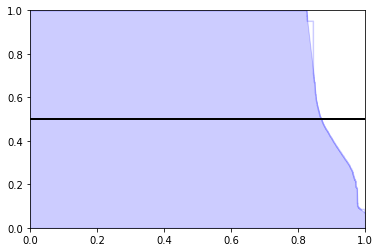

In [121]:
plt.step(x=recall, y=precision, color='b', alpha=0.2)
plt.fill_between(x=recall, y1=precision, color='b', alpha=0.2)
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.axhline(y=0.5, linewidth=2, color='k')

In [131]:
y_90 = (rfc_pred > 0.906667).astype('int')
print(precision_score(y_test, y_90))
print(recall_score(y_test, y_90))
print(f1_score(y_test, y_90))

1.0
0.825821175319912
0.9046024731038793


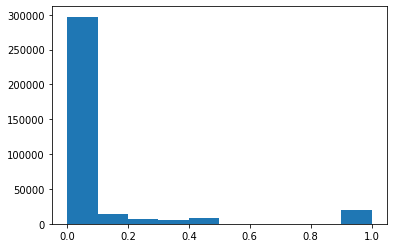

In [133]:
plt.hist(rfc_pred);

In [136]:
pd.DataFrame({'Feature Name': X_train.columns, 'Importance': rfc.feature_importances_}).sort_values(by='Importance', ascending=False)

,Feature Name,Importance
23,num_payments8,0.120221
31,sum_payments8,0.117659
30,sum_payments7,0.074976
22,num_payments7,0.072070
21,num_payments6,0.063004
29,sum_payments6,0.042955
7,sessions8,0.040348
15,launches8,0.039541
28,sum_payments5,0.036355
20,num_payments5,0.033727


In [158]:
confusion_matrix??

(array([0.5, 1.5]), [Text(0, 0.5, '0'), Text(0, 1.5, '1')])

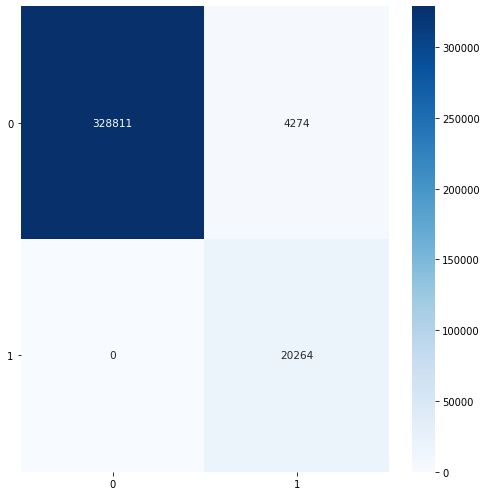

In [173]:
figsize=(7, 7)
normalized = None
cmap = plt.cm.Blues

cm = confusion_matrix(y_test, y_90, normalize='true' if normalized else None).T

plt.figure(figsize=figsize)
ax = sns.heatmap(cm, cmap=cmap, annot=True, fmt= '.2f' if normalized else 'd', annot_kws={'fontsize': np.sum(figsize) * 15 / 20 })
plt.tight_layout()
plt.yticks(rotation=0)
